In [1]:
suppressPackageStartupMessages({
    library(ggpubr)
    library(ggplot2)
    library(tidyverse)
    library(dplyr)
    library(viridis)
    library(ggpointdensity)
    library(ggthemes)
    library(patchwork)
})

DATA_DIR <- "~/github/C_albicans_biofilm_2021/Feb_2021_Kadosh_C_albicans_Biofilm_Planktonic/ribotricer_results/"

ribo_flucanazole_metagene = read.csv(file.path(DATA_DIR,  "/ribotricer_results_cleaned_gtf_longest/biofilm-ribo-1_metagene_profiles_5p.tsv"),
                                     sep="\t")

rownames(ribo_flucanazole_metagene) <- ribo_flucanazole_metagene$fragment_length
rna_flucanazole_metagene = read.csv(file.path(DATA_DIR, "/ribotricer_rna_results_cleaned_gtf_longest/biofilm-rna-1_metagene_profiles_5p.tsv"), sep="\t")
rownames(rna_flucanazole_metagene) <- rna_flucanazole_metagene$fragment_length


Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”


In [2]:
theme_Publication <- function(base_size=10, base_family="helvetica") {
      library(grid)
      library(ggthemes)
      (theme_foundation(base_size=base_size, base_family=base_family)
       + theme(plot.title = element_text(face = "bold",
                                         size = rel(1.2), hjust = 0.5),
               text = element_text(),
               panel.background = element_rect(colour = NA),
               plot.background = element_rect(colour = NA),
               panel.border = element_rect(colour = NA),
               axis.title = element_text(face = "bold",size = rel(1)),
               axis.title.y = element_text(face = "bold",angle=90,vjust =2),
               axis.title.x = element_text(face = "bold",vjust = -0.2),
               axis.text = element_text(face = "bold"), 
               axis.line = element_line(colour="black"),
               axis.ticks = element_line(),
               #panel.grid.major = element_line(colour="#f0f0f0"),
               panel.grid.major = element_blank(),
               panel.grid.minor = element_blank(),
               legend.key = element_rect(colour = NA),
               legend.position = "bottom",
               legend.direction = "horizontal",
               #legend.key.size= unit(0.2, "cm"),
               #legend.margin = unit(0, "cm"),
               #legend.title = element_text(face="italic"),
               #plot.margin=unit(c(10,5,5,5),"mm"),
               strip.background=element_rect(colour="#f0f0f0",fill="#f0f0f0"),
               strip.text = element_text(face="bold")
          ))
      
}

scale_fill_Publication <- function(...){
      library(scales)
      discrete_scale("fill","Publication",manual_pal(values = c("#386cb0","#fdb462","#7fc97f","#ef3b2c","#662506","#a6cee3","#fb9a99","#984ea3","#ffff33")), ...)

}

scale_colour_Publication <- function(...){
      library(scales)
      discrete_scale("colour","Publication",manual_pal(values = c("#386cb0","#fdb462","#7fc97f","#ef3b2c","#662506","#a6cee3","#fb9a99","#984ea3","#ffff33")), ...)

}

In [3]:
theme_set(theme_pubr(base_size = 12))

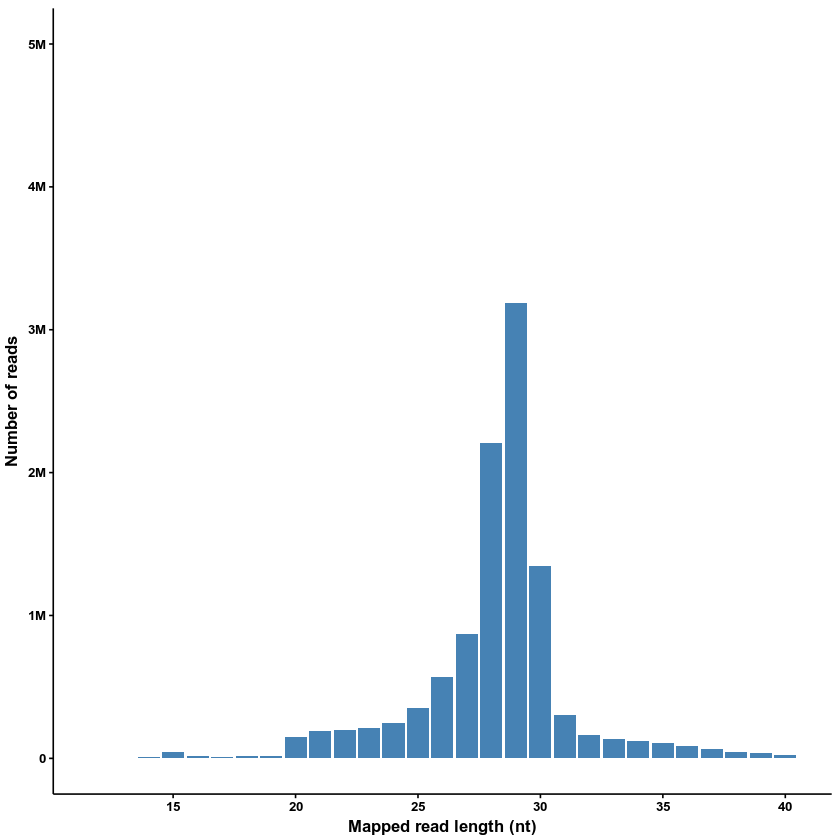

In [4]:
addUnits <- function(n) {
  labels <- ifelse(n < 1000, n,  # less than thousands
                   ifelse(n < 1e6, paste0(round(n/1e3), 'k'),  # in thousands
                          ifelse(n < 1e9, paste0(round(n/1e6), 'M'),  # in millions
                                 ifelse(n < 1e12, paste0(round(n/1e9), 'B'), # in billions
                                        ifelse(n < 1e15, paste0(round(n/1e12), 'T'), # in trillions
                                               'too big!'
                                        )))))
  return(labels)
}

read_counts <-read.csv(file.path(DATA_DIR,"/ribotricer_results_cleaned_gtf_longest/planktonic-ribo-1_bam_summary.txt"), skip = 9, sep=":")
colnames(read_counts) <- c("fragment_length", "counts")
read_counts <- read_counts[read_counts$fragment_length<41,]
p1 <- ggplot(read_counts, aes(fragment_length, counts)) + geom_bar(stat="identity", fill="steelblue") +   
expand_limits(y = 5*1e6) +
scale_y_continuous(labels = addUnits) + xlab("Mapped read length (nt)") + ylab("Number of reads") +
scale_x_continuous(breaks = c(15, 20, 25, 30, 35, 40, 45, 50)) + ylab("Number of reads") +
theme_Publication()
p1


In [5]:
DATA_DIR

[1] "~/github/C_albicans_biofilm_2021/Feb_2021_Kadosh_C_albicans_Biofilm_Planktonic/ribotricer_results/"

In [6]:
sample_name <- "biofilm-ribo-1"
for (sample_name in c("biofilm-ribo-1", "biofilm-ribo-2", "biofilm-ribo-3", 
                      "planktonic-ribo-1", "planktonic-ribo-2", "planktonic-ribo-3")) {
    
sample_name.rna <- gsub(pattern = "ribo", replacement = "rna", x = sample_name)

ribo_flucanazole_metagene_all = read.csv(file.path(DATA_DIR,  
                                                   paste0("/ribotricer_results_cleaned_gtf_longest/", 
                                                          sample_name,"_metagene_profiles_5p.tsv")),
                                     sep="\t")

rownames(ribo_flucanazole_metagene_all) <- ribo_flucanazole_metagene_all$fragment_length
rna_flucanazole_metagene_all = read.csv(file.path(DATA_DIR, 
                                                  paste0("/ribotricer_rna_results_cleaned_gtf_longest/", 
                                                         sample_name.rna, "_metagene_profiles_5p.tsv")), sep="\t")
rownames(rna_flucanazole_metagene_all) <- rna_flucanazole_metagene_all$fragment_length

read_metagene <- function(metagene_all, fragment_length){
    flucanazole_metagene <- metagene_all[as.character(fragment_length), "profile"]
    flucanazole_metagene <- gsub(pattern = "\\[", replacement = "c\\(", x = flucanazole_metagene)
    flucanazole_metagene <- gsub(pattern = "\\]", replacement = "\\)", x = flucanazole_metagene)
    flucanazole_metagene <- (eval(parse(text = flucanazole_metagene)))
    offset_5p <- as.numeric(metagene_all[as.character(fragment_length), "offset_5p"])
    df <- data.frame(position = -offset_5p + seq(length(flucanazole_metagene)) - 1, value = flucanazole_metagene,
                     frame = rep(c("Frame 1", "Frame 2", "Frame 3"), 
                                 times = length(flucanazole_metagene)/3))
    df$frame <- factor(df$frame, levels = c("Frame 1", "Frame 2", "Frame 3"))
    return (df)
    
}

rna_flucanazole_metagene <- read_metagene(rna_flucanazole_metagene_all, 30)
ribo_flucanazole_metagene <- read_metagene(ribo_flucanazole_metagene_all, 30)

options(repr.plot.width=11)
p2 <- ggplot(ribo_flucanazole_metagene %>% filter(position > -16 & position < 100), aes(position, value, fill=frame )) + geom_bar(stat="identity", width = 0.5) +  #xlim(-14, 100) +
scale_x_continuous(breaks = seq(from = -15, to = 99, by = 3), guide = guide_axis(angle=90), expand = c(0.01, 0)) + xlab("") + ylab("Normalized read\n counts") + 
#scale_y_continuous(expand )
expand_limits(y = 2) +
theme_Publication() + ggtitle(paste0("RPFs ", gsub("ribo-", "", sample_name))) + scale_fill_manual(values=c("#fc8d62", "#66c2a5", "#8da0cb"), name = "") + guides(fill = guide_legend(override.aes = list(size=1))) +
theme(
  axis.text.x = element_blank()) +
theme(legend.key.size = unit(0.35, "cm"))

p3 <- ggplot(rna_flucanazole_metagene %>% filter(position > -16 & position < 100), aes(position, value, fill=frame )) + geom_bar(stat="identity", width = 0.5) + xlim(-14, 100) +
scale_x_continuous(breaks = seq(from = -15, to = 99, by = 3), guide = guide_axis(angle=90), expand = c(0.01, 0)) + xlab("Distance from start codon (nt)") + ylab("Normalized read\n counts") + 
expand_limits(y = 2.5) +
theme_Publication() + ggtitle("Total RNA") + scale_fill_manual(values=c("#fc8d62", "#66c2a5", "#8da0cb"), name = "") + guides(fill = guide_legend(override.aes = list(size=1))) +
theme(legend.key.size = unit(0.35, "cm"))

p23 <- p2 / p3 
p23 <- p23+ plot_layout(guides = "collect") & theme(legend.position = 'right', legend.direction = "vertical")
p23
ggsave(paste0("plots/metagene_", gsub("ribo-", "", sample_name), ".png"))
    }

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Saving 6.67 x 6.67 in image
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Saving 6.67 x 6.67 in image
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Saving 6.67 x 6.67 in image
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Saving 6.67 x 6.67 in image
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Saving 6.67 x 6.67 in image
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Saving 6.67 x 6.67 in image


Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Saving 6.67 x 6.67 in image


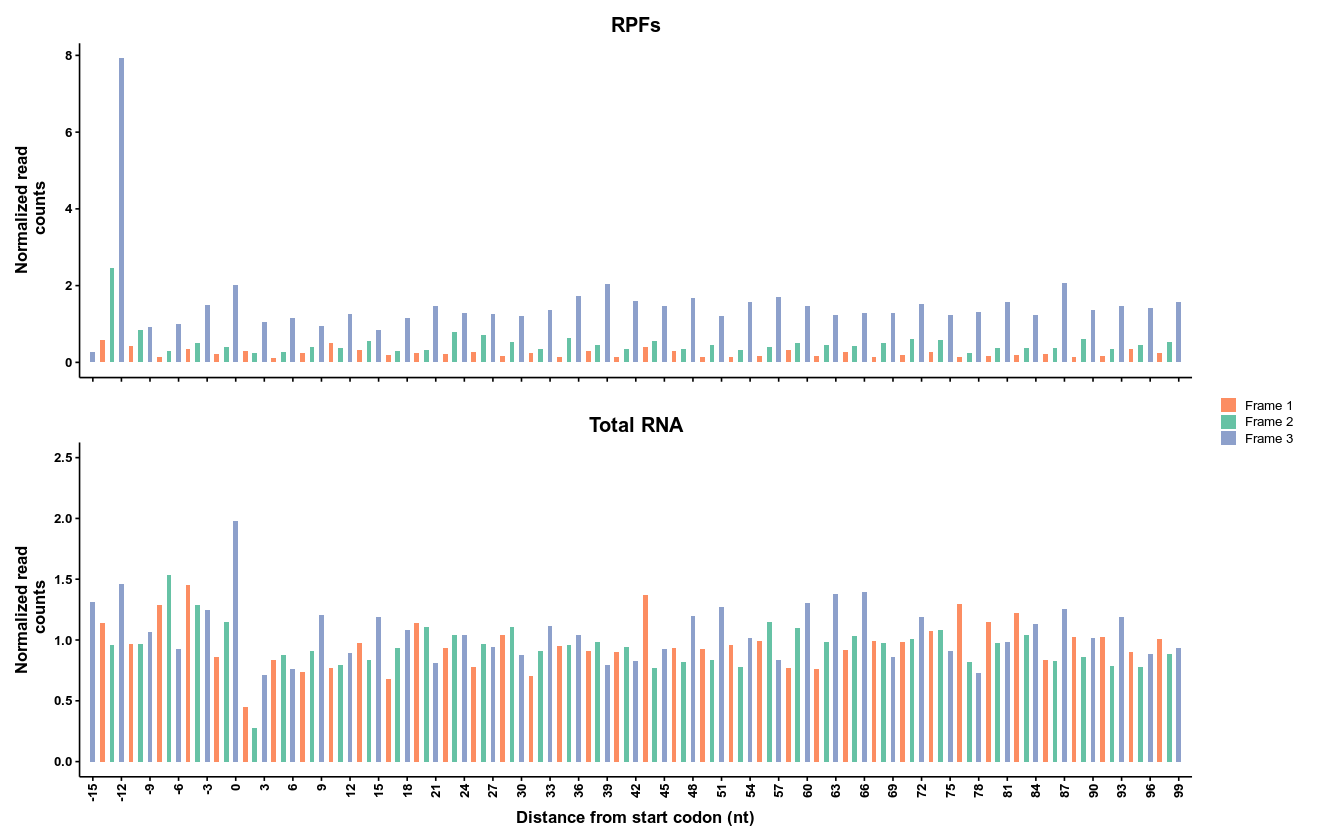

In [7]:
sample_name <- "biofilm-ribo-1"
sample_name.rna <- gsub(pattern = "ribo", replacement = "rna", x = sample_name)

ribo_flucanazole_metagene_all = read.csv(file.path(DATA_DIR,  
                                                   paste0("/ribotricer_results_cleaned_gtf_longest/", 
                                                          sample_name,"_metagene_profiles_5p.tsv")),
                                     sep="\t")

rownames(ribo_flucanazole_metagene_all) <- ribo_flucanazole_metagene_all$fragment_length
rna_flucanazole_metagene_all = read.csv(file.path(DATA_DIR, 
                                                  paste0("/ribotricer_rna_results_cleaned_gtf_longest/", 
                                                         sample_name.rna, "_metagene_profiles_5p.tsv")), sep="\t")
rownames(rna_flucanazole_metagene_all) <- rna_flucanazole_metagene_all$fragment_length

read_metagene <- function(metagene_all, fragment_length){
    flucanazole_metagene <- metagene_all[as.character(fragment_length), "profile"]
    flucanazole_metagene <- gsub(pattern = "\\[", replacement = "c\\(", x = flucanazole_metagene)
    flucanazole_metagene <- gsub(pattern = "\\]", replacement = "\\)", x = flucanazole_metagene)
    flucanazole_metagene <- (eval(parse(text = flucanazole_metagene)))
    offset_5p <- as.numeric(metagene_all[as.character(fragment_length), "offset_5p"])
    df <- data.frame(position = -offset_5p + seq(length(flucanazole_metagene)) - 1, value = flucanazole_metagene,
                     frame = rep(c("Frame 1", "Frame 2", "Frame 3"), 
                                 times = length(flucanazole_metagene)/3))
    df$frame <- factor(df$frame, levels = c("Frame 1", "Frame 2", "Frame 3"))
    return (df)
    
}

rna_flucanazole_metagene <- read_metagene(rna_flucanazole_metagene_all, 29)
ribo_flucanazole_metagene <- read_metagene(ribo_flucanazole_metagene_all, 29)

options(repr.plot.width=11)
p2 <- ggplot(ribo_flucanazole_metagene %>% filter(position > -16 & position < 100), aes(position, value, fill=frame )) + geom_bar(stat="identity", width = 0.5) +  #xlim(-14, 100) +
scale_x_continuous(breaks = seq(from = -15, to = 99, by = 3), guide = guide_axis(angle=90), expand = c(0.01, 0)) + xlab("") + ylab("Normalized read\n counts") + 
#scale_y_continuous(expand )
expand_limits(y = 2) +
theme_Publication() + ggtitle(paste0("RPFs")) + scale_fill_manual(values=c("#fc8d62", "#66c2a5", "#8da0cb"), name = "") + guides(fill = guide_legend(override.aes = list(size=1))) +
theme(
  axis.text.x = element_blank()) +
theme(legend.key.size = unit(0.35, "cm"))

p3 <- ggplot(rna_flucanazole_metagene %>% filter(position > -16 & position < 100), aes(position, value, fill=frame )) + geom_bar(stat="identity", width = 0.5) + xlim(-14, 100) +
scale_x_continuous(breaks = seq(from = -15, to = 99, by = 3), guide = guide_axis(angle=90), expand = c(0.01, 0)) + xlab("Distance from start codon (nt)") + ylab("Normalized read\n counts") + 
expand_limits(y = 2.5) +
theme_Publication() + ggtitle("Total RNA") + scale_fill_manual(values=c("#fc8d62", "#66c2a5", "#8da0cb"), name = "") + guides(fill = guide_legend(override.aes = list(size=1))) +
theme(legend.key.size = unit(0.35, "cm"))

p23 <- p2 / p3 
p23 <- p23+ plot_layout(guides = "collect") & theme(legend.position = 'right', legend.direction = "vertical")
p23
ggsave(paste0("plots/metagene_", gsub("ribo-", "", sample_name), ".png"))

In [8]:
plot_scatter <- function(tpm_df, col1, col2){
    
    tpm_df[, paste0("log2", col1)] <- log2(1+tpm_df[, col1])
    tpm_df[, paste0("log2", col2)] <- log2(1+tpm_df[, col2])
    print(head(tpm_df))

    
    col1n  <- gsub(pattern = "fluconazole-ribo-", replacement = "Ribo Biofilm #", x = col1)
    col1n  <- gsub(pattern = "nodrug-ribo-", replacement = "Ribo Planktonic #", x=col1n)
    col1n <- gsub(pattern = "fluconazole-rna-", replacement = "RNA Biofilm #", x=col1n)
    col1n <- gsub(pattern = "nodrug-rna-", replacement = "RNA Planktonic #", x=col1n)

    col2n  <- gsub(pattern = "fluconazole-ribo-", replacement = "Ribo Biofilm #", x = col2)
    col2n  <- gsub(pattern = "nodrug-ribo-", replacement = "Ribo Planktonic #", x=col2n)
    col2n <- gsub(pattern = "fluconazole-rna-", replacement = "RNA Biofilm #", x=col2n)
    col2n <- gsub(pattern = "nodrug-rna-", replacement = "RNA Planktonic #", x=col2n)

    p <- ggplot(tpm_df, aes_string(paste0("log2", col1), paste0("log2", col2))) +  geom_pointdensity(size=0.05) +
    scale_color_viridis() + xlab(paste(expression(log[2], "(1+TPM)", col1n)))  + ylab(paste(expression(log[2], "(1+TPM)", col1n)))

    return (p)
    }


In [9]:
tpm_df <- read.table( file.path(DATA_DIR, "region_counts/annotated_merged_tpm_ribo_rna.tsv"), sep="\t", check.names = F, header=1)
rownames(tpm_df) <- tpm_df$gene_id


In [10]:
col1 <- "biofilm-ribo-1"
col2 <- "biofilm-rna-1"
    
tpm_df[, paste0("log2", gsub(pattern = "-", replacement = "_", col1))] <- log2(1+tpm_df[, col1])
tpm_df[, paste0("log2", gsub(pattern = "-", replacement = "_", col2))] <- log2(1+tpm_df[, col2])

In [11]:
col1n  <- gsub(pattern = "biofim-ribo-", replacement = "Ribo Biofilm #", x = col1)
col1n  <- gsub(pattern = "planktonic-ribo-", replacement = "Ribo Planktonic #", x=col1n)
col1n <- gsub(pattern = "biofim-rna-", replacement = "RNA Biofilm #", x=col1n)
col1n <- gsub(pattern = "planktonic-rna-", replacement = "RNA Planktonic #", x=col1n)

col2n  <- gsub(pattern = "biofim-ribo-", replacement = "Ribo Biofilm #", x = col2)
col2n  <- gsub(pattern = "planktonic-ribo-", replacement = "Ribo Planktonic #", x=col2n)
col2n <- gsub(pattern = "biofim-rna-", replacement = "RNA Biofilm #", x=col2n)
col2n <- gsub(pattern = "planktonic-rna-", replacement = "RNA Planktonic #", x=col2n)

In [12]:
head(tpm_df)

,gene_id,biofilm-ribo-1,biofilm-ribo-2,biofilm-ribo-3,planktonic-ribo-1,planktonic-ribo-2,planktonic-ribo-3,biofilm-rna-1,biofilm-rna-2,biofilm-rna-3,planktonic-rna-1,planktonic-rna-2,planktonic-rna-3,log2biofilm_ribo_1,log2biofilm_rna_1
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
C1_00010W_A,C1_00010W_A,0,0.4621506,0.2653378,0,0.3280577,0.000000,0.4017778,0.2948211,0.0000000,0.000000,2.7416417,0.00000,0,0.4872577
C1_00010W_B,C1_00010W_B,0,0.0000000,0.0000000,0,0.0000000,0.000000,0.0000000,0.0000000,0.0000000,0.000000,0.0000000,0.00000,0,0.0000000
C1_00020C_A,C1_00020C_A,0,0.2512664,0.0000000,0,0.0000000,2.479321,12.6696536,0.0000000,24.1506330,6.661067,0.4968671,1.14301,0,3.7729048
C1_00020C_B,C1_00020C_B,0,0.0000000,0.0000000,0,0.0000000,0.000000,1.3106538,0.0000000,2.3636790,1.024780,0.0000000,0.00000,0,1.2083011
C1_00030C_A,C1_00030C_A,0,0.0000000,0.0000000,0,0.0000000,0.000000,0.0000000,0.0000000,0.1027687,0.000000,0.0000000,0.00000,0,0.0000000
C1_00030C_B,C1_00030C_B,0,0.0000000,0.0000000,0,0.0000000,0.000000,0.0000000,0.0000000,0.0000000,0.000000,0.0000000,0.00000,0,0.0000000


Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”


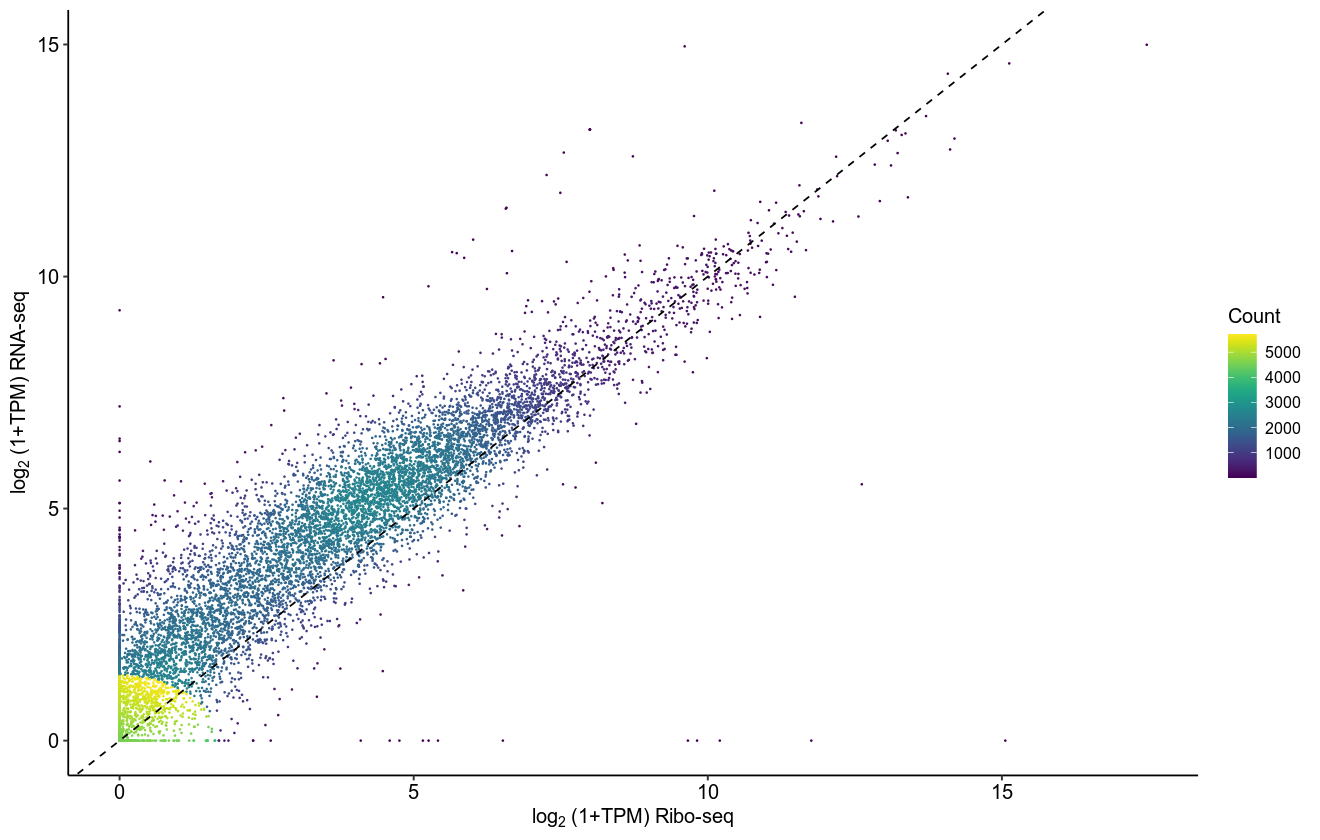

In [13]:
p <- ggplot(tpm_df, aes_string( paste0("log2", gsub(pattern = "-", replacement = "_", col1)), 
                                  paste0("log2", gsub(pattern = "-", replacement = "_", col2))
                                )) +  
geom_pointdensity(adjust = 5, size=0.1) +
geom_abline(color="black", linetype="dashed") + 
scale_color_viridis(name = "Count") + 
xlab(log[2] ~ "(1+TPM)" ~ 'Ribo-seq')  + ylab(log[2] ~ "(1+TPM)" ~ 'RNA-seq') + 
theme(legend.position="right")

p

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 4109 rows containing non-finite values (`stat_pointdensity()`).”


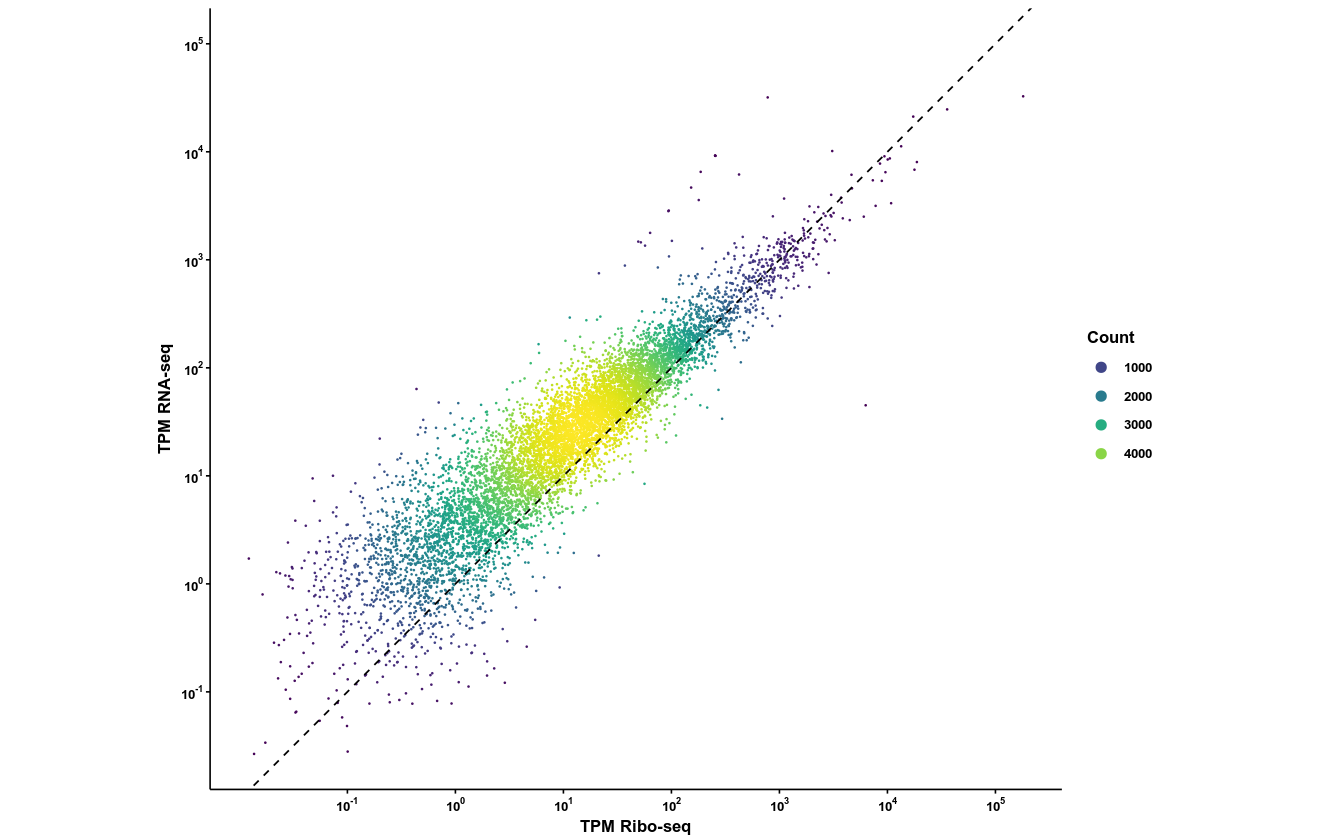

In [14]:
tpm_df <- read.table( file.path(DATA_DIR, "/region_counts/annotated_merged_tpm_ribo_rna.tsv"), sep="\t", check.names = T, header=1)
rownames(tpm_df) <- tpm_df$gene_id


pscatter <- ggplot(tpm_df, aes_string( paste0(gsub(pattern = "-", replacement = ".", col1)), 
                                  paste0(gsub(pattern = "-", replacement = ".", col2))
                                )) +  
geom_pointdensity(adjust = 5, size=0.1) +
scale_color_viridis(name = "Count") +
#scale_x_log10(   breaks = scales::trans_breaks("log10", function(x) 10^x),
#   labels = scales::trans_format("log10", scales::math_format(10^.x))
#) + scale_y_log10(   breaks = scales::trans_breaks("log10", function(x) 10^x),
#   labels = scales::trans_format("log10", scales::math_format(10^.x))
#) +
scale_x_log10(   breaks = c(0.1, 1, 10,100, 1000, 10000, 1e5),
   #labels = scales::trans_format("log10", scales::math_format(10^.x)),
              labels = function(lab) {
      do.call(
        expression,
        lapply(paste(log10(lab)), function(x) bquote(bold("10"^.(x))))
      )
    }
) + 
scale_y_log10(   breaks = c(0.1, 1, 10,100, 1000, 10000, 1e5),
   #labels = scales::trans_format("log10", scales::math_format(10^.x))
              labels = function(lab) {
      do.call(
        expression,
        lapply(paste(log10(lab)), function(x) bquote(bold("10"^.(x))))
      )
    }) +
expand_limits(y= 1e5)+            
  geom_abline(linetype="dashed") + 
                  xlab("TPM Ribo-seq")  + 
                  ylab('TPM RNA-seq') + 
                  theme_Publication() + theme(legend.position="right", legend.direction="vertical")  +
                  theme(axis.text.x = element_text(face="bold"), axis.text = element_text(face="bold"), text = element_text(face="bold"))  + 
                  guides(color = guide_legend(override.aes = list(size = 2.5))) +
                  coord_fixed( ratio=1) 
                  #+
#theme(axis.text.y = element_text(size=1, face="bold", color = "black")) +
#theme(axis.text.x = element_text(size=13, face="bold", color = "black"))

pscatter

In [15]:
library(ggtext)

In [16]:
suppressMessages({
    library(DESeq2)
    library(pheatmap)
    library(data.table)
    library(ggplot2)
    library(ggrepel)
    library(ggpubr)
    library(cowplot)
    library(RColorBrewer)})

In [17]:
BASE.PATH <- "~/github/C_albicans_biofilm_2021/Feb_2021_Kadosh_C_albicans_Biofilm_Planktonic/ribotricer_results/region_counts/"
DESIGN.FILEPATH <- "~/github/C_albicans_biofilm_2021/design_file.tsv"
CONDITIONS <- c("biofilm", "planktonic")


annotated.collaped_counts <- fread(file.path(BASE.PATH, "annotated_merged_counts_ribo_rna_collapsed_allele.tsv"))  #, sep='\t', stringsAsFactors=F)
superuorf.collaped_counts <- fread(file.path(BASE.PATH, "superuorf_merged_counts_ribo_rna_collapsed_allele.tsv"))  #, sep='\t', stringsAsFactors=F)

annotated.collaped_counts <- read.csv(file.path(BASE.PATH, "annotated_merged_counts_ribo_rna_collapsed_allele.tsv"), header = T, sep = "\t", stringsAsFactors = F, 
  check.names = F)
superuorf.collaped_counts <- read.csv(file.path(BASE.PATH, "superuorf_merged_counts_ribo_rna_collapsed_allele.tsv"), header = T, sep = "\t", stringsAsFactors = F, 
  check.names = F)

head(annotated.collaped_counts)

,gene_id,biofilm-ribo-1,biofilm-ribo-2,biofilm-ribo-3,planktonic-ribo-1,planktonic-ribo-2,planktonic-ribo-3,biofilm-rna-1,biofilm-rna-2,biofilm-rna-3,planktonic-rna-1,planktonic-rna-2,planktonic-rna-3
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,C1_00010W,0,2,1,0,1,0,1,1,0,0,6,0
2,C1_00020C,0,1,0,0,0,6,32,0,258,15,1,8
3,C1_00030C,0,0,0,0,0,0,0,0,1,0,0,0
4,C1_00040W,0,0,0,3,5,6,8,0,54,33,1,164
5,C1_00050C,0,0,0,0,0,0,0,0,2,0,0,0
6,C1_00060W,12091,4082,5143,7760,8423,6187,4404,2923,22558,5302,4581,19111


In [18]:
 countsToRLD <- function(counts.df, metadatadf){
    #metadata.df <- fread(DESIGN.FILEPATH)

        metadata.df <- read.csv(DESIGN.FILEPATH, header=T, stringsAsFactors=F, sep='\t')
condition <- factor(metadata.df$condition, levels=CONDITIONS)
    assay <- factor(metadata.df$assay, levels=c("rna", "ribo"))
    counts.df <- counts.df[, metadata.df$sample]
    coldata <- data.frame(row.names=colnames(counts.df), condition, assay)
    dds <- DESeqDataSetFromMatrix(countData=counts.df,
                                  colData=coldata,
                                  design=~condition+assay)
    #dds <- dds.mouse[apply(counts(dds), 1, function(row) all(row !=0 )),]
    dds <- DESeq(dds)
    dds <- dds[apply(counts(dds), 1, function(row) all(row !=0 )),]
    rld  <- rlogTransformation(dds , blind=TRUE)
    return (list("dds"=dds, "rld"=rld))
}
                     
plotClusterMap <- function(dds, rld, filename ){
    #metadata.df <- fread(DESIGN.FILEPATH)
    metadata.df <- read.csv(DESIGN.FILEPATH, header=T, stringsAsFactors=F, sep='\t')

    annotation.df <- as.data.frame(colData(dds)[, c("condition", "assay")])
    rownames(annotation.df) <- rownames(colData(dds))
    colnames(annotation.df) <- c("condition", "assay")
    mat_colors <- list(assay = get_palette("npg", 5)[3:4], condition=get_palette("npg", 2) )
    names(mat_colors$assay) <- unique(metadata.df$assay)
    names(mat_colors$condition) <- unique(metadata.df$condition)

    pheatmap(assay(rld), show_rownames = F, cluster_rows = F, annotation_col=annotation.df,  annotation_colors = mat_colors, filename=file.path('../plots/01.Exploratory/', filename))
    return (pheatmap(assay(rld), show_rownames = F, cluster_rows = F, annotation_col=annotation.df,  annotation_colors = mat_colors))
}



In [19]:
annotated.ddsrld <- countsToRLD(annotated.collaped_counts)
uorf.ddsrld <- countsToRLD(superuorf.collaped_counts)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



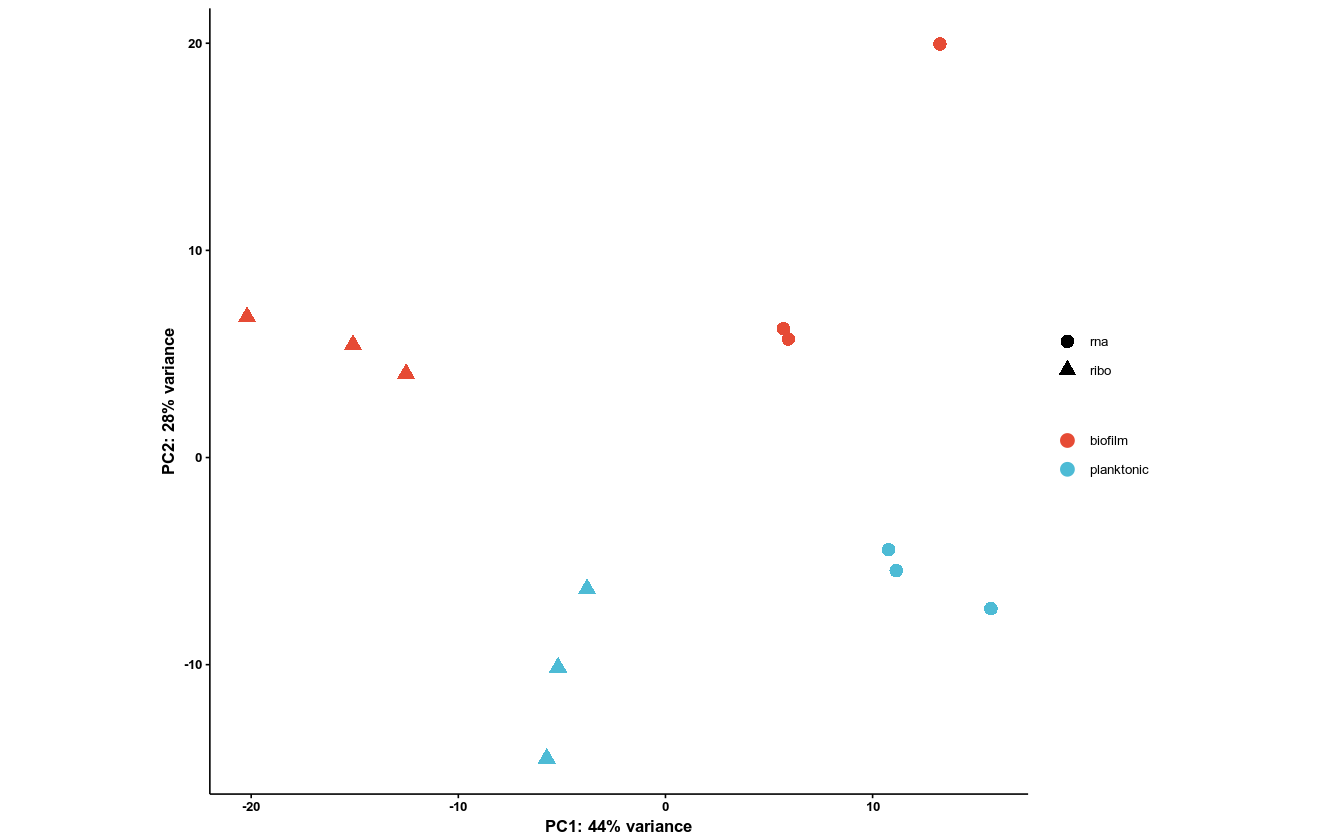

In [20]:
plotDESeq2PCA <- function(rld){
    data <- plotPCA(rld, intgroup = c("condition", "assay"), returnData=TRUE)
    percentVar <- round(100 * attr(data, "percentVar"))
    p <- ggscatter(data, "PC1", "PC2", color="condition", size = 3.5, shape="assay",  legend = "right", show.legend.text = FALSE) +# Indiviual fill color
    ggpubr::color_palette("npg") +
    xlab(paste0("PC1: ",percentVar[1],"% variance")) +
    ylab(paste0("PC2: ",percentVar[2],"% variance")) +
    coord_fixed() + 
    theme_Publication() +
    theme(legend.title=element_blank()) + 
    theme(legend.position="right", legend.direction="vertical")

    return (p)
}       
                     
                     
pca.plot <- plotDESeq2PCA(annotated.ddsrld$rld)
pca.plot

In [21]:
extrafont::loadfonts() 

In [22]:
options(repr.plot.width=8, repr.plot.height=11)
p <- (p1 | pscatter | pca.plot) / p23

p2 <- p + plot_annotation(tag_levels = "A") & theme(plot.tag = element_text(face = "bold", size=16))


Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 4109 rows containing non-finite values (`stat_pointdensity()`).”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 4109 rows containing non-finite values (`stat_pointdensity()`).”


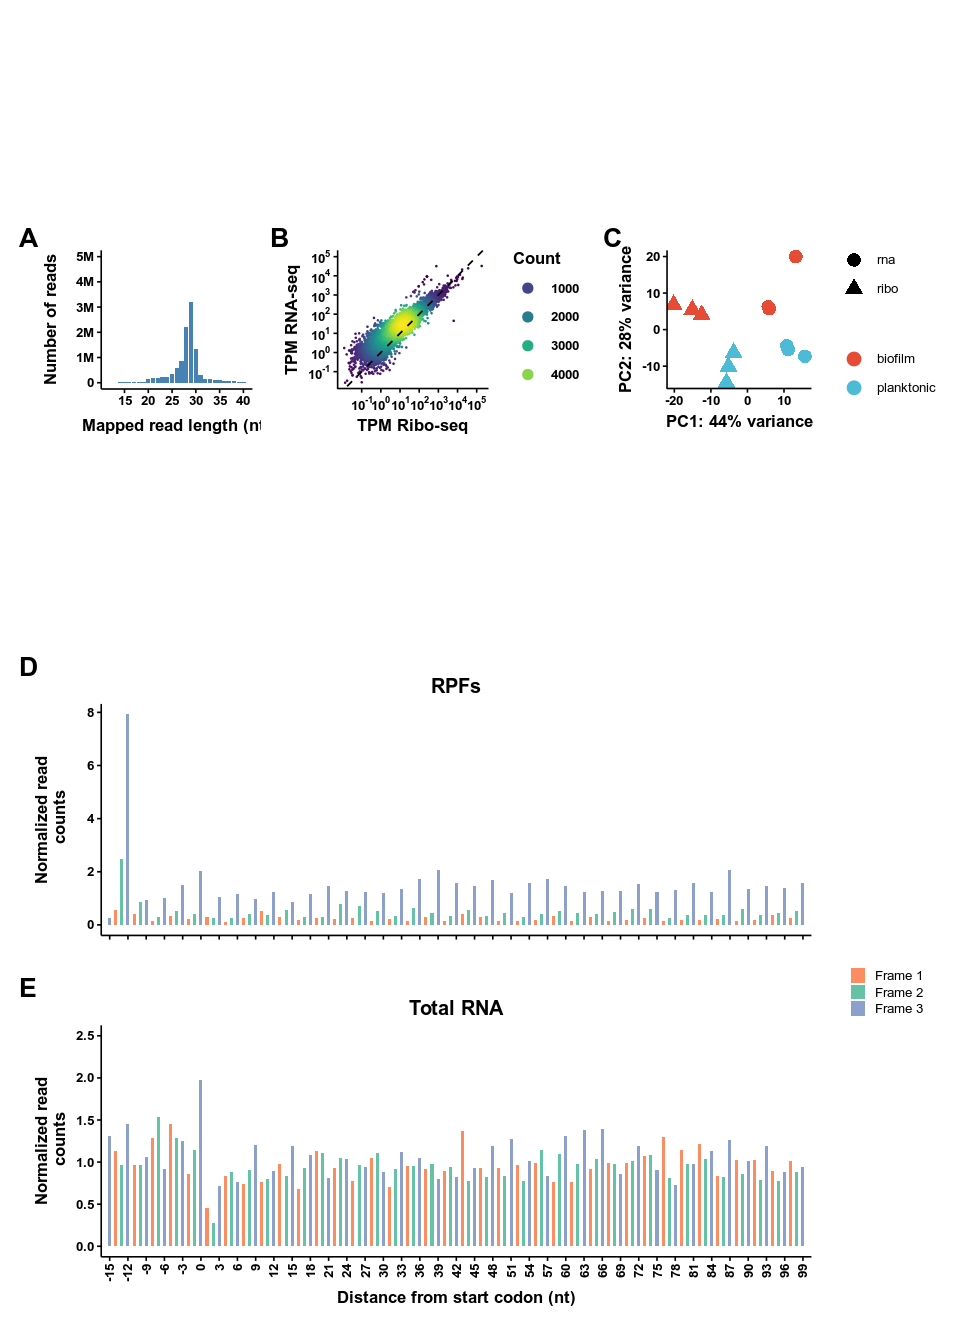

In [26]:
p2
ggsave("~/github/C_albicans_biofilm_2021/Draft_Figures/Figure1.svg", device=svg, width=12, height=9)
